In [114]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# 1. 이미지 확인 

In [115]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

120
tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFea

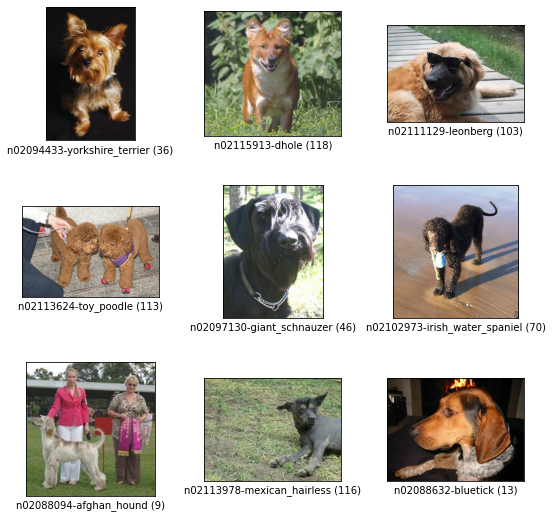

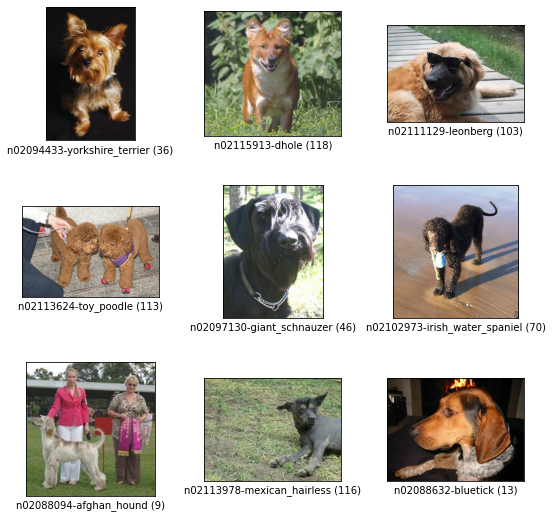

In [116]:
num_classes = ds_info.features["label"].num_classes
print(num_classes)
print(ds_info)
tfds.show_examples(ds_train, ds_info)

# 2. 모델 파이프라인 구축

In [134]:
#모델은 resnet50 구조를 사용
def get_model():
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224,224,3),
            pooling='avg',
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return resnet50


# 3. 이미지 처리 함수 생성

## 3-1 cutmix

In [135]:
#cut mix 단순히 이미지 위에 다른이미지를 올려둔 상태라 보면됨 

# 모든 이미지에 대해 cutmix을 돌리면 정확도가 현저히 낮아짐으로써 일정 확률을 줌
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max


# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


# mix two labels
def mix_2_labels(h, w, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = w
    image_size_y = h
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=0.5, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        rand = tf.cast(tf.random.uniform([1], 0, 1),tf.float32)
        if rand<0.5:
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        else:
            j = i
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        h=image_a.shape[0]
        w=image_a.shape[1]
        mixed_labels.append(mix_2_labels(h, w, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


## 3-2 mixup  

In [136]:
# mixup 두개의 이미지를 비율에 맞춰 보간 처리

## 모든 이미지에 대해 mixup을 돌리면 정확도가 현저히 낮아짐으로써 일정 확률을 줌
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=0.5, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        
        rand = tf.cast(tf.random.uniform([1], 0, 1),tf.float32)
        if rand<0.5:
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        else:
            j = i
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


## 3-3 기본적인 이미지 처리(스케일링, 좌우반전, 밝기 조절)

In [137]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else: # cutmix와 mixup 은 원핫벡터변환과정을 내장함수로 가지고있음
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [138]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,# 데이터를 이미지,라벨로 반환, 해당 데이터셋에는 bbox도 있는데 bbox데이터를 꺼낼려면 어떻게??
    shuffle_files=True,
    with_info=True,
)

# 4. 데이터셋 전처리

In [139]:
normal_ds = apply_normalize_on_dataset(ds_train, batch_size=16)
aug_ds = apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=True)
cutmix_ds = apply_normalize_on_dataset(ds_train, batch_size=16,with_aug=True, with_cutmix=True)
mixup_ds = apply_normalize_on_dataset(ds_train, batch_size=16,with_aug=True, with_mixup=True)
test_ds = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=16)

In [140]:
# 기본 + cutmix 가 기본데이터 + cutmix인가? aug->cutmix인가

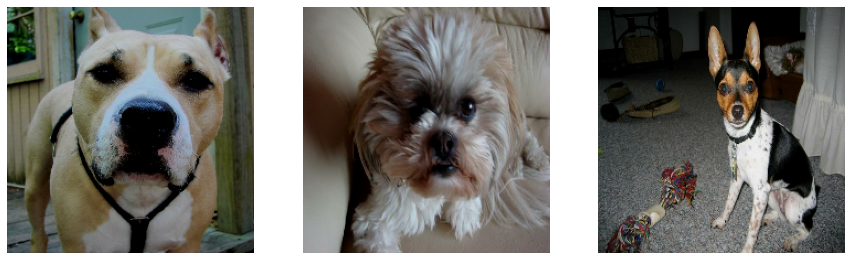

In [165]:
#시간되면 현 블록에서 이미지 처리 된거 확인해보기
# augmentaion 데이터 확인
plt.figure(figsize=(15, 5))

for images,labels in aug_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

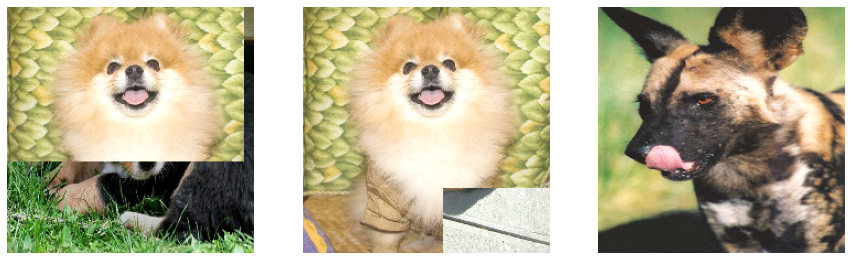

In [164]:
#cutmix 데이터 확인
plt.figure(figsize=(15, 5))

for images,labels in cutmix_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

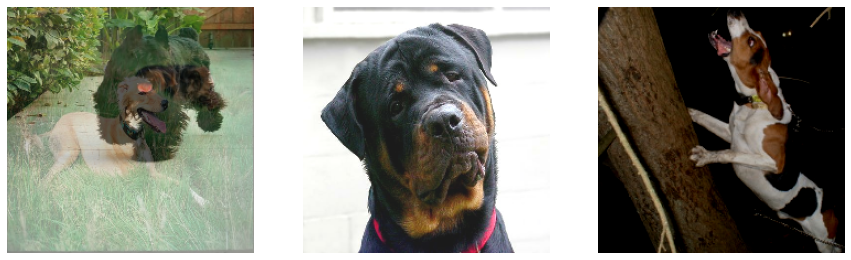

In [163]:
#mixup 데이터 확인
plt.figure(figsize=(15, 5))

for images,labels in mixup_ds.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

# 5. 모델 학습

###  데이터 셋 별로 학습 (no_aug, aug, aug+cutmix, aug+mixup)

In [142]:
normal_resnet50 = get_model()
aug_resnet50 = get_model()
cutmix_resnet50 = get_model()
mixup_resnet50 = get_model()

In [143]:
def model_train(model, train_ds, test_ds, EPOCH=40):
    model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'])
    
    history = model.fit(
        train_ds, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=test_ds,
        verbose=1,
        use_multiprocessing=True,
    )
    return history


In [144]:
normal_history=model_train(normal_resnet50, normal_ds, test_ds, EPOCH=15)

Epoch 1/15
750/750 [==============================] - 178s 229ms/step - loss: 2.2271 - accuracy: 0.4450 - val_loss: 3.4890 - val_accuracy: 0.1837
Epoch 2/15
750/750 [==============================] - 157s 209ms/step - loss: 0.7118 - accuracy: 0.8023 - val_loss: 1.1704 - val_accuracy: 0.6628
Epoch 3/15
750/750 [==============================] - 156s 209ms/step - loss: 0.2243 - accuracy: 0.9541 - val_loss: 0.9561 - val_accuracy: 0.7142
Epoch 4/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0614 - accuracy: 0.9948 - val_loss: 0.9047 - val_accuracy: 0.7429
Epoch 5/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0275 - accuracy: 0.9993 - val_loss: 0.9135 - val_accuracy: 0.7410
Epoch 6/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0175 - accuracy: 0.9992 - val_loss: 0.9256 - val_accuracy: 0.7439
Epoch 7/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.9360 -

In [146]:
aug_history=model_train(aug_resnet50, aug_ds, test_ds, EPOCH=15)

Epoch 1/15
750/750 [==============================] - 164s 210ms/step - loss: 2.1447 - accuracy: 0.4562 - val_loss: 2.4574 - val_accuracy: 0.3684
Epoch 2/15
750/750 [==============================] - 156s 209ms/step - loss: 0.9128 - accuracy: 0.7414 - val_loss: 1.1183 - val_accuracy: 0.6734
Epoch 3/15
750/750 [==============================] - 156s 209ms/step - loss: 0.4818 - accuracy: 0.8695 - val_loss: 1.0916 - val_accuracy: 0.6792
Epoch 4/15
750/750 [==============================] - 156s 209ms/step - loss: 0.2583 - accuracy: 0.9386 - val_loss: 1.1269 - val_accuracy: 0.6765
Epoch 5/15
750/750 [==============================] - 156s 208ms/step - loss: 0.1374 - accuracy: 0.9762 - val_loss: 0.9593 - val_accuracy: 0.7239
Epoch 6/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0787 - accuracy: 0.9898 - val_loss: 0.9336 - val_accuracy: 0.7392
Epoch 7/15
750/750 [==============================] - 157s 209ms/step - loss: 0.0490 - accuracy: 0.9936 - val_loss: 0.9680 -

In [147]:
cutmix_history=model_train(cutmix_resnet50, cutmix_ds, test_ds, EPOCH=15)

Epoch 1/15
750/750 [==============================] - 166s 210ms/step - loss: 3.1133 - accuracy: 0.3170 - val_loss: 3.2828 - val_accuracy: 0.2224
Epoch 2/15
750/750 [==============================] - 158s 210ms/step - loss: 2.0701 - accuracy: 0.5573 - val_loss: 1.5052 - val_accuracy: 0.5815
Epoch 3/15
750/750 [==============================] - 157s 210ms/step - loss: 1.7172 - accuracy: 0.6598 - val_loss: 1.2859 - val_accuracy: 0.6379
Epoch 4/15
750/750 [==============================] - 157s 210ms/step - loss: 1.5278 - accuracy: 0.7290 - val_loss: 1.1783 - val_accuracy: 0.6660
Epoch 5/15
750/750 [==============================] - 158s 210ms/step - loss: 1.3786 - accuracy: 0.7773 - val_loss: 1.2749 - val_accuracy: 0.6502
Epoch 6/15
750/750 [==============================] - 157s 210ms/step - loss: 1.2621 - accuracy: 0.8109 - val_loss: 1.2110 - val_accuracy: 0.6621
Epoch 7/15
750/750 [==============================] - 172s 229ms/step - loss: 1.1890 - accuracy: 0.8357 - val_loss: 1.2101 -

In [148]:
mixup_history=model_train(mixup_resnet50, mixup_ds, test_ds, EPOCH=15)

Epoch 1/15
750/750 [==============================] - 167s 212ms/step - loss: 3.0771 - accuracy: 0.3247 - val_loss: 3.3789 - val_accuracy: 0.2151
Epoch 2/15
750/750 [==============================] - 158s 210ms/step - loss: 2.0473 - accuracy: 0.5777 - val_loss: 1.8146 - val_accuracy: 0.5117
Epoch 3/15
750/750 [==============================] - 158s 210ms/step - loss: 1.7112 - accuracy: 0.6817 - val_loss: 1.5462 - val_accuracy: 0.5749
Epoch 4/15
750/750 [==============================] - 158s 210ms/step - loss: 1.5025 - accuracy: 0.7508 - val_loss: 1.3920 - val_accuracy: 0.6107
Epoch 5/15
750/750 [==============================] - 158s 210ms/step - loss: 1.3434 - accuracy: 0.7993 - val_loss: 1.1026 - val_accuracy: 0.6936
Epoch 6/15
750/750 [==============================] - 158s 210ms/step - loss: 1.2692 - accuracy: 0.8315 - val_loss: 1.0283 - val_accuracy: 0.7083
Epoch 7/15
750/750 [==============================] - 158s 210ms/step - loss: 1.1868 - accuracy: 0.8570 - val_loss: 1.1505 -

# 6. Loss, Validation_Accuracy 결과

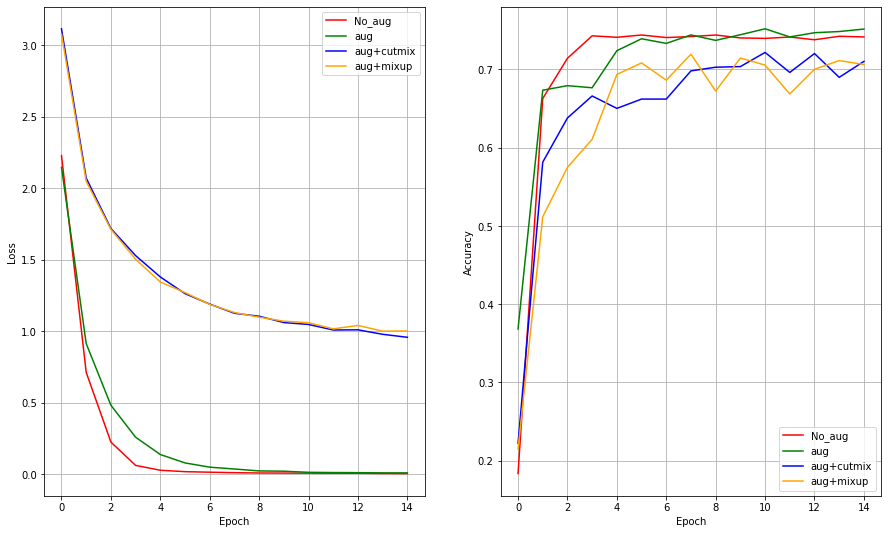

In [162]:
import matplotlib.pyplot as plt

#print(normal_history.history.keys())
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(normal_history.history['loss'], 'r', label='No_aug')
ax1.plot(aug_history.history['loss'], 'g', label='aug')
ax1.plot(cutmix_history.history['loss'], 'b', label='aug+cutmix')
ax1.plot(mixup_history.history['loss'], 'orange', label='aug+mixup')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(normal_history.history['val_accuracy'], 'r', label='No_aug')
ax2.plot(aug_history.history['val_accuracy'], 'g', label='aug')
ax2.plot(cutmix_history.history['val_accuracy'], 'b', label='aug+cutmix')
ax2.plot(mixup_history.history['val_accuracy'], 'orange', label='aug+mixup')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid()

fig.show()



# 7. 결론

## 15epoch로 학습한 결과 평가지표와 손실값은 아래표와 같다

<p style="text-align:center;font-size:20px;">val_accuracy</p>

|epochs|simple scaling|augmentaion|aug+cutmix|aug+cutmax|
|:-------:|:-------:|:-----------:|:----------:|:----------:|
|15epoch|74.15%|75.15%|71.02%|70.63%|

<p style="text-align:center;font-size:20px;">Train_Loss</p>

|epochs|simple scaling|augmentaion|aug+cutmix|aug+cutmax|
|:-------:|:-------:|:-----------:|:----------:|:----------:|
|15epoch|0.0043|0.0088|0.9569|1.0011|

해당 지표를 통해 image augmentaion을 이용했을때 가장 높은 정확도를 가진 것을 알 수 있다. 이 내용을 통해 augmentaion dataset은 단순히 image scaling만 진행한 dataset에 비해 데이터의 다양성을 가졌기에 testset에 대해 유연한 정확도를 가질 수 있었다. 

하지만 augmentaion processing 후 cutmix, cutmax processing을 추가한 dataset이 분명 다양성측면에선 높은데 augmentaion dataset보다 낮은 정확도가 나온 것에 대한 원인은 loss값을 통해 하나의 가설을 세울 수 있다고 본다

simple scaling, augmentaion은 loss가 거의 0에 수렴한 상태(overfitting)이고 testset 정확도는 일정 값에 수렴한 후 부터 거의 변화가 없다. 하지만  cutmix, cutmax dataset 의경우는 살짝 다르다 loss는 계속 꾸준히 작게나마 감소하고 있고 정확도 또한 다른 dataset에 비해 낮은 편이지만 상승하는 모습을 볼 수 있다. 이 뜻은 해당 데이터셋이 성장가능성을 가지고있다고 생각하고 model parameter나 image processing 확률을 적절하게 분포시킨다면 좀 더 높은 정확도를 가질 수 있다고 본다. 

가설을 증명하기위해 epoch 수와 lr을 늘려보며 테스트를 진행해볼 필요성이 있다고 본다.

# 자체 평가

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
  네, CutMix와 mixup 기법을 이미지에 적용시켜 모델학습을 진행하였습니다.
  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
  네, 좌우반전, 이미지 밝기 등의 augmentaion을 수행하였고 cutmix, mixup의 경우에는 일정 확률을 주는게 학습이 좀 더 잘되는 경향을 파악하여 수정후 적용하였습니다.
  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
  네, 전체적으로 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였습니다